In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def generate_triplets(X, y):
    '''
    this function get batch of features and set them as anchors and generate positve and
    negative instances corresponding to anchors
    Args:
        X: features that are considered as anchors with the shape (batch_size, c, h, w)
        y: labels with the shape (batch_size)
    Returns:
        batch of anchors, positive and negative instances as a tuple
    '''

    anchor, positive, negative = [], [], []

    for i in range(len(X)):
        # Select anchor image and label
        X_anchor = X[i]
        anchor_label = y[i]

        # Select positive example (same class as anchor)
        positive_indices = (y == anchor_label).nonzero(as_tuple=True)[0]
        positive_idx = torch.randint(0, len(positive_indices), (1,))
        X_pos = X[positive_indices[positive_idx]]

        # Select negative example (different class from anchor)
        negative_indices = (y != anchor_label).nonzero(as_tuple=True)[0]
        negative_idx = torch.randint(0, len(negative_indices), (1,))
        X_neg = X[negative_indices[negative_idx]]

        anchor.append(X_anchor)
        positive.append(X_pos)
        negative.append(X_neg)

    return torch.stack(anchor), torch.stack(positive), torch.stack(negative)

In [ ]:
def load_data(batch_size:int):
    '''
    this function load "airplane" and "automobile" classes of cifar-10 data and performs
    suitable transformations on dataset
    Args:
        batch_size: int number as batch size
    Returns:
        train_loader: train dataloader object
        test_loader: test dataloader object
    '''

    # Set random seed for reproducibility
    torch.manual_seed(42)

    # our dataset should be prepared in the same way as the original data that went into the resnet50 model.
    auto_trans = ResNet50_Weights.DEFAULT.transforms()
    transform = transforms.Compose([transforms.ToTensor(),
                                    auto_trans
                                    ])

    # Load the entire CIFAR-10 dataset
    train_dataset_all = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset_all = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    classes = ["airplane", "automobile"]

    # Filter the dataset to include only the selected classes
    filtered_idx = [i for i, label in enumerate(train_dataset_all.targets) if train_dataset_all.classes[label] in classes]
    train_dataset = torch.utils.data.Subset(train_dataset_all, filtered_idx)
    filtered_idx = [i for i, label in enumerate(test_dataset_all.targets) if test_dataset_all.classes[label] in classes]
    test_dataset = torch.utils.data.Subset(test_dataset_all, filtered_idx)

    # Define data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [ ]:
BATCH_SIZE = 32
train_dataloader, test_dataloader = load_data(BATCH_SIZE)

100%|██████████| 170498071/170498071 [00:02<00:00, 60377696.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 313 batches of 32
Length of test dataloader: 63 batches of 32


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
class ResnetModel(nn.Module):
    '''
    this class is our model that is based on resnet50.
    fc layer has been replaced with two fc layer with shape (2048, 128) and (128, 2)
    '''
    #initializing model
    def __init__(self, device=device):
        super().__init__()
        weights = ResNet50_Weights.DEFAULT
        self.model = resnet50(weights=weights).to(device)
        self.model.fc = nn.Identity()
        self.classifier_layer = nn.Sequential(nn.Linear(2048, 128),
                                              nn.ReLU(inplace=True),
                                              nn.Linear(128, 2)).to(device)

        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.test_loss, self.test_acc = 0., 0.
        #freeze all parameters of a model
        for param in self.parameters():
            param.requires_grad = False

        torch.manual_seed(42)

    #model forward pass
    def forward(self, x):
        embeddings = self.model(x)
        class_outputs = self.classifier_layer(embeddings)
        return embeddings, class_outputs

    def train_classifier(self, dataloader, batch_size, num_epochs=5):
        '''
        this function freeze conv layers and just train fc layers
        we use this function for part 1 and part 2
        Arg:
            dataloader: get train dataloader
            batch_size: int number as batch size
            num_epochs: number of epochs
        Return:
            total_loss_list: a list that contains losses after each epoch
            train_acc_list: a list that contains train accuracy after each epoch
        '''

        total_loss_list = []
        train_acc_list = []
        for param in self.classifier_layer.parameters():
            param.requires_grad = True

        loss_fn = nn.CrossEntropyLoss()

        for epoch in tqdm(range(num_epochs)):
            self.train()

            correct_pred = 0.
            train_acc = 0.
            total_loss = 0.

            for X, y in iter(dataloader):
                X = X.to(device)
                y = y.to(device)

                _, outputs = self(X)
                loss = loss_fn(outputs, y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                _, predictions = torch.max(outputs, 1)
                correct_pred += torch.eq(predictions, y).float().sum()
                total_loss += loss
            train_acc = correct_pred / (len(dataloader) * batch_size)
            print(f"train accuracy = {train_acc} in epoch{epoch}")
            train_acc_list.append(train_acc)
            total_loss_list.append(total_loss)
        return train_acc_list, total_loss_list

    def train_feature_extractor(self, dataloader, num_epochs=5):
        '''
        this function use for training conv layers using triplet loss
        Arg:
            dataloader: get train dataloader
            num_epochs: number of epochs
        Return:
            total_loss_list: a list that contains losses after each epoch
            train_acc_list: empty list
        '''
        total_loss_list = []
        train_acc_list = []
        for param in self.model.parameters():
            param.requires_grad = True

        self.train()
        triplet_loss = nn.TripletMarginLoss(margin=0.5, p=2)

        for epoch in tqdm(range(num_epochs)):
            total_loss = 0.

            for X, y in iter(dataloader):
                triplet_data_tuple = generate_triplets(X, y)
                anchor = triplet_data_tuple[0].to(device)
                positive = triplet_data_tuple[1].squeeze(dim=1).to(device)
                negative = triplet_data_tuple[2].squeeze(dim=1).to(device)

                self.optimizer.zero_grad()
                anchor_out, _ = self(anchor)
                positive_out, _ = self(positive)
                negative_out, _ = self(negative)

                loss = triplet_loss(anchor_out, positive_out, negative_out)
                loss.backward()
                self.optimizer.step()
                total_loss += loss
                del anchor
                del positive
                del negative
            total_loss_list.append(total_loss)

            if device == 'cuda':
                import gc
                torch.cuda.empty_cache()
                gc.collect()

        return train_acc_list, total_loss_list

    def train_model(self, dataloader, batch_size, num_epochs=5):
        '''
        this function train a conv layers and classifier using hybrid loss
        Arg:
            dataloader: get train dataloader
            batch_size: int number as batch size
            num_epochs: number of epochs
        Return:
            total_loss_list: a list that contains losses after each epoch
            train_acc_list: a list that contains train accuracy after each epoch
        '''
        total_loss_list = []
        train_acc_list = []
        for param in self.parameters():
            param.requires_grad = True

        self.train()
        triplet_loss = nn.TripletMarginLoss(margin=0.5, p=2)
        cross_entropy_loss = nn.CrossEntropyLoss()

        for epoch in tqdm(range(num_epochs)):
            total_loss, train_acc, correct_pred = 0., 0., 0.

            for X, y in iter(dataloader):
                triplet_data_tuple = generate_triplets(X, y)
                y = y.to(device)
                anchor = triplet_data_tuple[0].to(device)
                positive = triplet_data_tuple[1].squeeze(dim=1).to(device)
                negative = triplet_data_tuple[2].squeeze(dim=1).to(device)

                self.optimizer.zero_grad()
                anchor_out, outputs = self(anchor)
                positive_out, _ = self(positive)
                negative_out, _ = self(negative)

                loss = triplet_loss(anchor_out, positive_out, negative_out) + cross_entropy_loss(outputs, y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss
                _, predictions = torch.max(outputs, 1)
                correct_pred += torch.eq(predictions, y).float().sum()
                del y
                del anchor
                del positive
                del negative
                del outputs
                if device == 'cuda':
                    import gc
                    torch.cuda.empty_cache()
                    gc.collect()
            train_acc = correct_pred / (len(dataloader) * batch_size)
            print(f"train accuracy = {train_acc} in epoch{epoch}")
            train_acc_list.append(train_acc)
            total_loss_list.append(total_loss)



        return train_acc_list, total_loss_list


    def test_model(self, dataloader, batch_size):
        '''
        this function is used for test model
        Arg:
            dataloader: test dataloader
            batch_size: int number as batch size
        Return:
            test accuracy and loss
        '''
        loss_fn = nn.CrossEntropyLoss()
        self.eval()

        correct_pred = 0.

        with torch.inference_mode():
            for X, y in iter(dataloader):
                X = X.to(device)
                y = y.to(device)

                _, outputs = self(X)
                loss = loss_fn(outputs, y)

                self.test_loss += loss
                _, predictions = torch.max(outputs, 1)
                correct_pred += torch.eq(predictions, y).float().sum()
                del X
                del y
        if device == 'cuda':
            import gc
            torch.cuda.empty_cache()
            gc.collect()

        self.test_acc = correct_pred / (len(dataloader) * batch_size)
        return self.test_loss, self.test_acc


In [ ]:
model1 = ResnetModel()
model1

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s] 


ResnetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
train_acc_list = []
total_loss_list = []
train_acc_list, total_loss_list = model1.train_classifier(train_dataloader, BATCH_SIZE)

 20%|██        | 1/5 [00:34<02:18, 34.50s/it]

train accuracy = 0.9322084784507751 in epoch0


 40%|████      | 2/5 [01:03<01:33, 31.10s/it]

train accuracy = 0.9562699794769287 in epoch1


 60%|██████    | 3/5 [01:32<01:00, 30.30s/it]

train accuracy = 0.9569688439369202 in epoch2


 80%|████████  | 4/5 [02:02<00:30, 30.21s/it]

train accuracy = 0.9612619876861572 in epoch3


100%|██████████| 5/5 [02:33<00:00, 30.71s/it]

train accuracy = 0.9645566940307617 in epoch4


In [ ]:
total_losses = torch.tensor(total_loss_list, device = 'cpu')
train_accuracies = torch.tensor(train_acc_list, device = 'cpu')
train_accuracies, total_losses

(tensor([0.9322, 0.9563, 0.9570, 0.9613, 0.9646]),
 tensor([53.7963, 35.4817, 34.0932, 30.3374, 26.5255]))

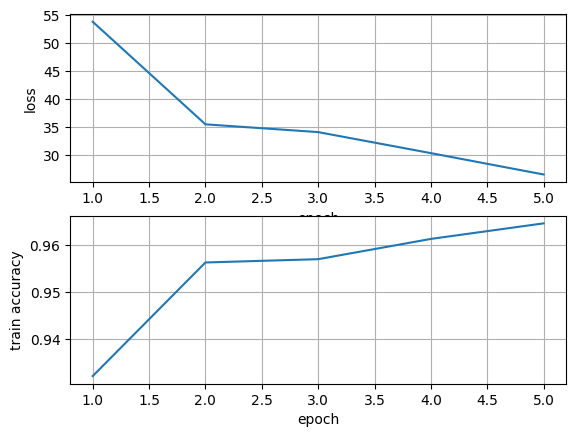

In [ ]:
epochs = [1, 2, 3, 4, 5]
fig, ax = plt.subplots(2, 1)

ax[0].plot(epochs, total_losses)
ax[0].set(xlabel='epoch', ylabel='loss')
ax[0].grid()

ax[1].plot(epochs, train_accuracies)
ax[1].set(xlabel='epoch', ylabel='train accuracy')
ax[1].grid()

plt.show()

In [ ]:
test_loss, test_acc = model1.test_model(test_dataloader, BATCH_SIZE)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_acc}")

test loss = 6.112537860870361
test accuracy = 0.9568452835083008


In [ ]:
model2 = ResnetModel()
model2

ResnetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
total_loss_list = []
_, total_loss_list = model2.train_feature_extractor(train_dataloader)

100%|██████████| 5/5 [23:12<00:00, 278.56s/it]


In [ ]:
total_losses = torch.tensor(total_loss_list, device = 'cpu')
total_losses

tensor([60.6119, 21.7944,  8.4569,  4.0069,  6.3250])

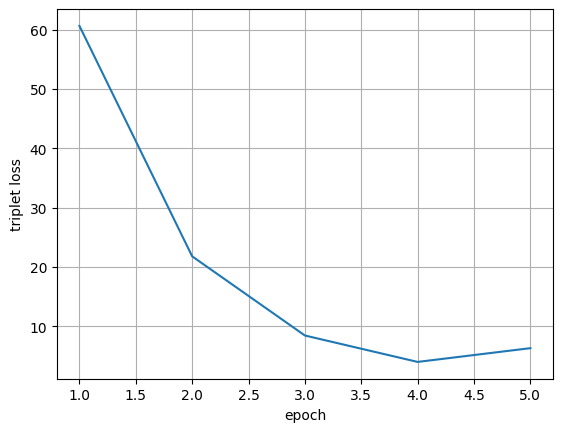

In [ ]:
epochs = [1, 2, 3, 4, 5]
fig, ax = plt.subplots(1, 1)

ax.plot(epochs, total_losses)
ax.set(xlabel='epoch', ylabel='triplet loss')
ax.grid()

plt.show()

In [ ]:
for param in model2.parameters():
    param.requires_grad = False
train_acc_list = []
total_loss_list = []
train_acc_list, total_loss_list = model2.train_classifier(train_dataloader, BATCH_SIZE)

 20%|██        | 1/5 [00:30<02:00, 30.00s/it]

train accuracy = 0.9817292094230652 in epoch0


 40%|████      | 2/5 [01:00<01:31, 30.55s/it]

train accuracy = 0.989217221736908 in epoch1


 60%|██████    | 3/5 [01:31<01:01, 30.57s/it]

train accuracy = 0.9896165728569031 in epoch2


 80%|████████  | 4/5 [02:01<00:30, 30.49s/it]

train accuracy = 0.9901158213615417 in epoch3


100%|██████████| 5/5 [02:32<00:00, 30.51s/it]

train accuracy = 0.9910143613815308 in epoch4


In [ ]:
total_losses = []
total_losses = torch.tensor(total_loss_list, device = 'cpu')
train_accuracies = torch.tensor(train_acc_list, device = 'cpu')
train_accuracies, total_losses

(tensor([0.9817, 0.9892, 0.9896, 0.9901, 0.9910]),
 tensor([20.9644,  8.4095,  7.8986,  7.6906,  5.8673]))

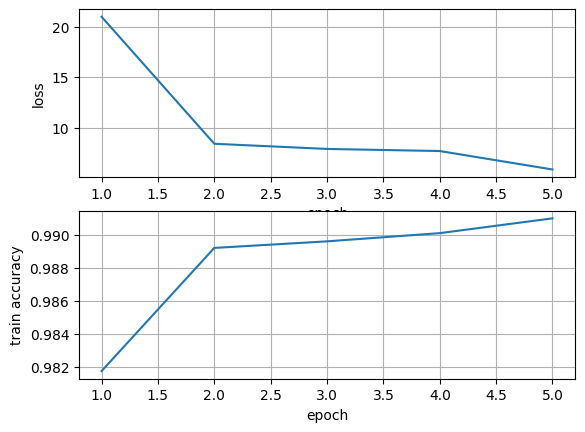

In [ ]:
epochs = [1, 2, 3, 4, 5]
fig, ax = plt.subplots(2, 1)

ax[0].plot(epochs, total_losses)
ax[0].set(xlabel='epoch', ylabel='loss')
ax[0].grid()

ax[1].plot(epochs, train_accuracies)
ax[1].set(xlabel='epoch', ylabel='train accuracy')
ax[1].grid()

plt.show()

In [ ]:
test_loss, test_acc = model2.test_model(test_dataloader, BATCH_SIZE)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_acc}")

test loss = 1.7471505403518677
test accuracy = 0.9841270446777344


In [ ]:
model3 = ResnetModel()
model3

ResnetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
total_loss_list = []
total_acc_list = []
total_acc_list, total_loss_list = model3.train_model(train_dataloader, BATCH_SIZE)

 20%|██        | 1/5 [06:32<26:10, 392.71s/it]

train accuracy = 0.9419928193092346 in epoch0


 40%|████      | 2/5 [13:01<19:32, 390.69s/it]

train accuracy = 0.9701477289199829 in epoch1


 60%|██████    | 3/5 [19:29<12:58, 389.19s/it]

train accuracy = 0.9777355790138245 in epoch2


 80%|████████  | 4/5 [25:55<06:27, 387.90s/it]

train accuracy = 0.9817292094230652 in epoch3


100%|██████████| 5/5 [32:17<00:00, 387.50s/it]

train accuracy = 0.9885183572769165 in epoch4


In [ ]:
total_losses = torch.tensor(total_loss_list, device = 'cpu')
train_accuracies = torch.tensor(total_acc_list, device = 'cpu')
train_accuracies, total_losses

(tensor([0.9420, 0.9701, 0.9777, 0.9817, 0.9885]),
 tensor([100.4359,  46.7476,  29.6581,  24.8980,  16.1813]))

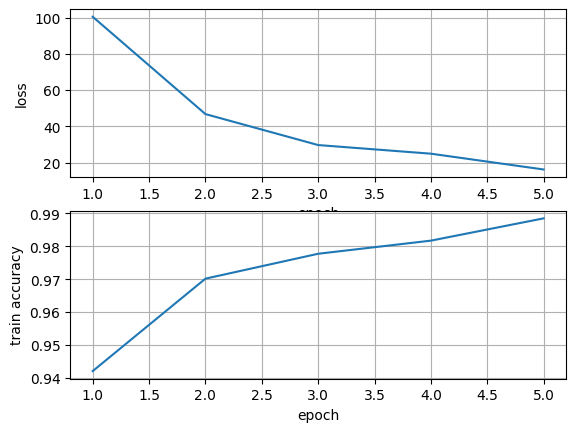

In [ ]:
epochs = [1, 2, 3, 4, 5]
fig, ax = plt.subplots(2, 1)

ax[0].plot(epochs, total_losses)
ax[0].set(xlabel='epoch', ylabel='loss')
ax[0].grid()

ax[1].plot(epochs, train_accuracies)
ax[1].set(xlabel='epoch', ylabel='train accuracy')
ax[1].grid()

plt.show()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
test_loss, test_acc = model3.test_model(test_dataloader, BATCH_SIZE)
print(f"test loss = {test_loss}")
print(f"test accuracy = {test_acc}")

test loss = 2.768343210220337
test accuracy = 0.9751984477043152
